# Sentiment Analysis

# Table of contents<a class="anchor" id="m"></a>

* [Data Preparation](#one)
    * [Loading in initial datasets](#1.1)
    * [Preprocessing](#1.2)
    * [Train, test, validation split](#1.3)
* [Model Training](#two)
    * [Hyperparameter tuning](#2.1)
        * [Results of optimally tuned model](#2.2)
    * [Actual Training to create full model for sentiment analysis using full set of data](#2.3)
* [Testing model](#three)

In [15]:
import numpy as np
import pandas as pd
import pickle
import string

#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

#For data visualization
import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.patches as mpatches
import seaborn as sns

%matplotlib inline

pd.options.plotting.backend = "plotly"

import random
import json
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import os
from math import nan
from pandas import read_csv
from matplotlib import pyplot
from tensorflow import keras
from tensorflow.keras import Model
import itertools
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets
import keras_tuner as kt
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import losses
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import RNN
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from pandas import read_csv
from sklearn.metrics import mean_squared_error
import math
from future.utils import iteritems
from numpy import savetxt
from numpy import asarray
from numpy import savez_compressed
from statistics import mean
from tensorflow.keras import layers
from collections import Counter
from conlleval import evaluate
from emot.emo_unicode import UNICODE_EMOJI  # for emojis
from emot.emo_unicode import EMOTICONS_EMO  # for emoticons

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/D190003/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Preparation<a class="anchor" id="one"></a>
[Contents Page](#m)

## Data Loading<a class="anchor" id="1.1"></a>
(DATAFRAME COMBINATION)

In [4]:
dfa.groupby('category').nunique()

,clean_text
category,
negative,197
positive,4188


In [72]:
data = pd.read_csv('all-data.csv', names=['category', 'clean_text'], encoding='latin-1')
df1 = pd.read_csv('Twitter_Data.csv')
df2 = pd.read_csv('apple-twitter-sentiment-texts.csv')
df2 = df2.rename(columns={'text': 'clean_text', 'sentiment':'category'})
df2['category'] = df2['category'].map({-1: -1.0, 0: 0.0, 1:1.0})
df3 = pd.read_csv('finalSentimentdata2.csv')
df3 = df3.rename(columns={'text': 'clean_text', 'sentiment':'category'})
df3['category'] = df3['category'].map({'sad': -1.0, 'anger': -1.0, 'fear': -1.0, 'joy':1.0})
df3 = df3.drop(['Unnamed: 0'], axis=1)
df4 = pd.read_csv('Tweets.csv')
df4 = df4.rename(columns={'text': 'clean_text', 'airline_sentiment':'category'})
df4['category'] = df4['category'].map({'negative': -1.0, 'neutral': 0.0, 'positive':1.0})
df4 = df4[['category','clean_text']]
df = pd.concat([df1, df2, df3, df4], ignore_index=True)
df.dropna(axis=0, inplace=True)
df['category'] = df['category'].map({-1.0:'negative', 0.0:'neutral', 1.0:'positive'})
die= pd.concat([df, data], ignore_index=True)

In [73]:
die

,clean_text,category
0,when modi promised “minimum government maximum...,negative
1,talk all the nonsense and continue all the dra...,neutral
2,what did just say vote for modi welcome bjp t...,positive
3,asking his supporters prefix chowkidar their n...,positive
4,answer who among these the most powerful world...,positive
...,...,...
187170,LONDON MarketWatch -- Share prices ended lower...,negative
187171,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral
187172,Operating profit fell to EUR 35.4 mn from EUR ...,negative
187173,Net sales of the Paper segment decreased to EU...,negative


In [68]:
die.groupby('category').nunique()

,clean_text
category,
negative,48213
neutral,61949
positive,76768


In [10]:
def con(elon):
    ''' Convert tweet text into a sequence of words '''
    
    # convert to lowercase
    text = elon.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal tweet ->", die['clean_text'][21])
print("\nProcessed tweet ->", con(die['clean_text'][21]))

# Apply data processing to each sentence
X = list(map(con, die['clean_text']))

# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(die['category'])


Original tweet -> with firm belief the leadership shri narendra modi bjp entering into politics given form file nomination for the khammam parliamentary seat proceeding khammam today 

Processed tweet -> ['firm', 'belief', 'leadership', 'shri', 'narendra', 'modi', 'bjp', 'enter', 'polit', 'given', 'form', 'file', 'nomin', 'khammam', 'parliamentari', 'seat', 'proceed', 'khammam', 'today']


## Preprocessing<a class="anchor" id="1.2"></a>

In [63]:
# Function to replace/remove junk seen during manual labelling
# Converting emojis to words
def convert_emojis(text):
    for i in text:
        if i in UNICODE_EMOJI.keys():
            try:
                text = text.replace(i, f' {"_".join(UNICODE_EMOJI[i].replace(",","").replace(":","").split())}')
            except:
                continue
    
    return text


# Converting emoticons to words    
def convert_emoticons(text):
    for i in text.split():
        if i in EMOTICONS_EMO.keys():
            text = text.replace(i, "_".join(EMOTICONS_EMO[i].replace(",","").split()))
    return text


# Function for removing urls
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)


# custom punctuation
punctuations = string.punctuation + "´‘’“”…–€«»"

# # Function to replace/remove junk seen during manual labelling
# def dejunk(text):
#     text = re.sub(r"𝓟𝓻𝓲𝓬𝓮𝓵𝓮𝓼𝓼 𝓲𝓼 𝓽𝓱𝓮 𝓶𝓸𝓼𝓽 𝓿𝓪𝓵𝓾𝓪𝓫𝓵𝓮 𝓪𝓼𝓼𝓮𝓽 𝓽𝓸 𝓸𝔀𝓷 𝓲𝓯 𝔂𝓸𝓾 𝓪𝓻𝓮 𝓵𝓾𝓬𝓴𝔂 𝓮𝓷𝓸𝓾𝓰𝓱 𝓽𝓸 𝓫𝓮 𝓪𝓫𝓵𝓮 𝓽𝓸 𝓪𝓬𝓺𝓾𝓲𝓻𝓮 𝓲𝓽", 
#                   "priceless is the most valuable asset to own if you are lucky enough to be able to acquire it", text)
    
#     text = re.sub(r"&amp;", "and", text)  # &
#     text = re.sub(r"&gt;", "", text)  # >
#     text = re.sub(r"&lt;", "", text)  # <
#     text = re.sub(r"1⃣", "1. ", text)
#     text = re.sub(r"2⃣", "2. ", text)
#     text = re.sub(r"3⃣", "3. ", text)
#     text = re.sub(r"4⃣", "4. ", text)

#     return text

#making a text-cleaning function
def preprocess_text(text):
    
    #convert lowercase
    cleaned_text = text.lower()

#     # Replace/remove junk text
#     cleaned_text = dejunk(cleaned_text)
    
    #convert emoji into words
    cleaned_text = convert_emojis(cleaned_text)
    
    # convert emoticons into words
    cleaned_text = convert_emoticons(cleaned_text)
    
    # remove urls
    cleaned_text = remove_urls(cleaned_text)
    
#     #remove punctuations
#     nopunc = [char for char in cleaned_text if char not in punctuations]
#     nopunc = ''.join(nopunc)
    
    #remove stopwords
    clean_words = [word for word in cleaned_text.split() if word.lower() not in stopwords.words('english')]

    #return cleaned text
    return ' '.join(clean_words)

die["clean_text"] = die["clean_text"].apply(preprocess_text)

die

,clean_text,category
0,modi promised “minimum government maximum gove...,negative
2,say vote modi welcome bjp told rahul main camp...,positive
3,asking supporters prefix chowkidar names modi ...,positive
4,answer among powerful world leader today trump...,positive
8,upcoming election india saga going important p...,positive
...,...,...
187169,helsinki thomson financial - shares cargotec f...,negative
187170,london marketwatch -- share prices ended lower...,negative
187172,operating profit fell eur 35.4 mn eur 68.8 mn ...,negative
187173,net sales paper segment decreased eur 221.6 mn...,negative


In [64]:
die.to_pickle("aym.pkl")

In [27]:
die['clean_text']

0         modi promised “minimum government maximum gove...
1                    talk nonsense continue drama vote modi
2         say vote modi welcome bjp told rahul main camp...
3         asking supporters prefix chowkidar names modi ...
4         answer among powerful world leader today trump...
                                ...                        
187170    london marketwatch -- share prices ended lower...
187171    rinkuskiai 's beer sales fell 6.5 per cent 4.1...
187172    operating profit fell eur 35.4 mn eur 68.8 mn ...
187173    net sales paper segment decreased eur 221.6 mn...
187174    sales finland decreased 10.5 % january , sales...
Name: clean_text, Length: 187175, dtype: object

In [65]:
die=pd.read_pickle("aym.pkl")
die

,clean_text,category
0,modi promised “minimum government maximum gove...,negative
2,say vote modi welcome bjp told rahul main camp...,positive
3,asking supporters prefix chowkidar names modi ...,positive
4,answer among powerful world leader today trump...,positive
8,upcoming election india saga going important p...,positive
...,...,...
187169,helsinki thomson financial - shares cargotec f...,negative
187170,london marketwatch -- share prices ended lower...,negative
187172,operating profit fell eur 35.4 mn eur 68.8 mn ...,negative
187173,net sales paper segment decreased eur 221.6 mn...,negative


In [76]:
dice=die
dice=dice.drop(dice[dice.category =="neutral"].index)
dice

,clean_text,category
0,when modi promised “minimum government maximum...,negative
2,what did just say vote for modi welcome bjp t...,positive
3,asking his supporters prefix chowkidar their n...,positive
4,answer who among these the most powerful world...,positive
8,with upcoming election india saga going import...,positive
...,...,...
187169,HELSINKI Thomson Financial - Shares in Cargote...,negative
187170,LONDON MarketWatch -- Share prices ended lower...,negative
187172,Operating profit fell to EUR 35.4 mn from EUR ...,negative
187173,Net sales of the Paper segment decreased to EU...,negative


In [127]:
dice.groupby('category').nunique()

,clean_text
category,
negative,48213
positive,76768


In [77]:
die

,clean_text,category
0,when modi promised “minimum government maximum...,negative
1,talk all the nonsense and continue all the dra...,neutral
2,what did just say vote for modi welcome bjp t...,positive
3,asking his supporters prefix chowkidar their n...,positive
4,answer who among these the most powerful world...,positive
...,...,...
187170,LONDON MarketWatch -- Share prices ended lower...,negative
187171,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral
187172,Operating profit fell to EUR 35.4 mn from EUR ...,negative
187173,Net sales of the Paper segment decreased to EU...,negative


In [96]:
# # saving
# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
#with open('tokenizer.pickle', 'rb') as handle:
#    tokenizer = pickle.load(handle)
max_words=5000
def get_sequences2(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    print("Vocab length:", len(tokenizer.word_index) + 1)
    
    max_seq_length = np.max(list(map(lambda x: len(x), sequences)))
    print("Maximum sequence length:", 63) # max_seq_length
    
    sequences = pad_sequences(sequences, maxlen=63, padding='post')
    
    return sequences
#sequences = get_sequences2(die['clean_text'])

In [98]:
def get_sequences(texts):
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(texts)
    
    sequences = tokenizer.texts_to_sequences(texts)
    print("Vocab length:", len(tokenizer.word_index) + 1)
    
    max_seq_length = np.max(list(map(lambda x: len(x), sequences)))
    print("Maximum sequence length:", max_seq_length) #63
    
    sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')
    
    return sequences,tokenizer

In [99]:
sequences, tokenizer = get_sequences(die['clean_text'])
print('After Tokenization & Padding \n', sequences[21])

Vocab length: 130170
Maximum sequence length: 63
After Tokenization & Padding 
 [  12 2601 4517    2  361  385   34    1   24  191  229  181  852 1577
 2099    4    2 3256  313  119    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]


In [100]:
sequences2, tokenizer2 = get_sequences(dice['clean_text'])
print('After Tokenization & Padding \n', sequences2[231])

Vocab length: 104649
Maximum sequence length: 63
After Tokenization & Padding 
 [   1   76  390  236 1574   17 2135   86  665  804  665  770  144 1739
  500   28   20   76  537  173   10 1953  448 2747 4104  307 3926   76
    6    1 1867    9  422    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]


## Train test validation split <a class="anchor" id="1.3"></a>

In [101]:
y = pd.get_dummies(die['category'])
X_train, X_test, y_train, y_test = train_test_split(sequences, y, test_size=0.3,stratify=y, random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train+Val Set ->', X_train.shape, y_train.shape)
#print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train+Val Set -> (131022, 63) (131022, 3)
Test Set -> (56153, 63) (56153, 3)


In [102]:
X_train

array([[ 259,    5, 2181, ...,    0,    0,    0],
       [   6,  516,   15, ...,    0,    0,    0],
       [   3,  182,   55, ...,    0,    0,    0],
       ...,
       [  30,   50,   13, ...,    0,    0,    0],
       [  33,    1,   73, ...,    0,    0,    0],
       [  37,  637,   91, ...,    0,    0,    0]], dtype=int32)

In [103]:
y_train

,negative,neutral,positive
161586,0,1,0
99687,0,0,1
74421,1,0,0
5305,0,0,1
27749,1,0,0
...,...,...,...
4724,0,0,1
184057,0,0,1
2668,0,0,1
113306,0,1,0


In [115]:
y_train1=y_train.drop(['negative', 'positive'], axis=1)
y_test1=y_test.drop(['negative', 'positive'], axis=1)

# y_train1.drop(['neutral', 'positive'], axis=1)
y_train1

,neutral
161586,1
99687,0
74421,0
5305,0
27749,0
...,...
4724,0
184057,0
2668,0
113306,1


In [116]:
y2 = pd.get_dummies(dice['category'])
X_train2, X_test2, y_train2, y_test2 = train_test_split(sequences2, y2, test_size=0.3,stratify=y2, random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train+Val Set ->', X_train2.shape, y_train2.shape)
#print('Validation Set ->', X_val2.shape, y_val2.shape)
print('Test Set ->', X_test2.shape, y_test2.shape)

Train+Val Set -> (87629, 63) (87629, 2)
Test Set -> (37556, 63) (37556, 2)


In [117]:
y_train2

,negative,positive
6460,1,0
27545,0,1
92345,0,1
152759,0,1
133063,0,1
...,...,...
9558,0,1
165805,1,0
92461,0,1
16847,1,0


In [128]:
y_train3=y_train2.drop([ 'negative'], axis=1)
y_test3=y_test2.drop([ 'negative'], axis=1)

y_train3

,positive
6460,0
27545,1
92345,1
152759,1
133063,1
...,...
9558,1
165805,0
92461,1
16847,0


# Model Training<a class="anchor" id="two"></a>
[Contents Page](#m)

In [118]:
def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Hyperparameter tuning <a class="anchor" id="2.1"></a>

In [110]:
def m0(hp):
    
    vocab_size = 5000
    embedding_size = hp.Int('emb',min_value=4,max_value=64,step=4)
    #epochs=hp.Int('epoch',min_value=32,max_value=256,step=32)
    learning_rate = hp.Float('learning',min_value=1e-4, max_value=2e-1, sampling='log')
    decay_rate = learning_rate / 100
    momentum = hp.Choice('mom',values=[0.7,0.8,0.9,0.99])

    sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    # Build model
    model= Sequential()
    model.add(Embedding(vocab_size, embedding_size, input_length=63))
    model.add(Conv1D(filters=hp.Int('filt',min_value=32,max_value=128,step=32), kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    #change up 
    model.add(Bidirectional(LSTM(hp.Int('neuron',min_value=32,max_value=256,step=32),kernel_regularizer=l2(0.05),recurrent_regularizer=l2(0.05))))
    model.add(Dropout(hp.Float('dp',min_value=2e-3, max_value=2e-1, sampling='log')))
    model.add(Dense(1, activation='sigmoid'))#softmax test later
    tf.keras.utils.plot_model(model, show_shapes=True)
    
    model.compile(loss='binary_crossentropy', optimizer=sgd, #categorical_crossentropy
               metrics=['accuracy',Precision(), Recall()])

    return model

tuner= kt.Hyperband(m0,objective='val_loss',max_epochs=10,factor=3,overwrite=True)
stop_early=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

tuner.search(X_train,y_train1,epochs=100,validation_split=0.1,callbacks=[stop_early])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
tuner.search_space_summary()
print(f"""Optimal result: filter={best_hps.get('filt')},dropout={best_hps.get('dp')},number of neurons={best_hps.get('neuron')},momentum={best_hps.get('mom')},embedding={best_hps.get('emb')},learning rate={best_hps.get('learning')}""")

Trial 3 Complete [00h 02m 50s]
val_loss: 0.57783043384552

Best val_loss So Far: 0.5774580240249634
Total elapsed time: 00h 09m 01s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
52                |16                |emb
0.00011712        |0.0011467         |learning
0.9               |0.9               |mom
96                |96                |filt
64                |128               |neuron
0.090569          |0.016858          |dp
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round



/home/D190003/CZ1016/base/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/2
3685/3685 [==============================] - 55s 14ms/step - loss: 14.2856 - accuracy: 0.7398 - precision: 0.2583 - recall: 0.0054 - val_loss: 9.2133 - val_accuracy: 0.7357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/2
3433/3685 [==========================>...] - ETA: 3s - loss: 6.5151 - accuracy: 0.7422 - precision: 0.0000e+00 - recall: 0.0000e+00

KeyboardInterrupt: 

In [199]:
batch_size = 64
model=m0()
stop_early=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)
history = model.fit(X_train, y_train,
                      batch_size=batch_size, epochs=20,validation_split=0.1, verbose=1,callbacks=[stop_early])

/home/D190003/CZ1016/base/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.


Epoch 1/20
50/50 [==============================] - 5s 49ms/step - loss: 3.0162 - accuracy: 0.9403 - precision_13: 0.9403 - recall_13: 0.9403 - val_loss: 0.2834 - val_accuracy: 0.9429 - val_precision_13: 0.9429 - val_recall_13: 0.9429
Epoch 2/20
50/50 [==============================] - 1s 25ms/step - loss: 0.1946 - accuracy: 0.9543 - precision_13: 0.9543 - recall_13: 0.9543 - val_loss: 0.2198 - val_accuracy: 0.9429 - val_precision_13: 0.9429 - val_recall_13: 0.9429
Epoch 3/20
50/50 [==============================] - 1s 25ms/step - loss: 0.1906 - accuracy: 0.9543 - precision_13: 0.9543 - recall_13: 0.9543 - val_loss: 0.2234 - val_accuracy: 0.9429 - val_precision_13: 0.9429 - val_recall_13: 0.9429
Epoch 4/20
50/50 [==============================] - 1s 25ms/step - loss: 0.1866 - accuracy: 0.9543 - precision_13: 0.9543 - recall_13: 0.9543 - val_loss: 0.2218 - val_accuracy: 0.9429 - val_precision_13: 0.9429 - val_recall_13: 0.9429
Epoch 5/20
50/50 [==============================] - 1s 25ms/

In [109]:
def m0(hp):
    
    vocab_size = 5000
    embedding_size = hp.Int('emb',min_value=4,max_value=64,step=4)
    #epochs=hp.Int('epoch',min_value=32,max_value=256,step=32)
    learning_rate = hp.Float('learning',min_value=1e-4, max_value=2e-1, sampling='log')
    decay_rate = learning_rate / 100
    momentum = hp.Choice('mom',values=[0.7,0.8,0.9,0.99])

    sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    # Build model
    model= Sequential()
    model.add(Embedding(vocab_size, embedding_size, input_length=63))
    model.add(Conv1D(filters=hp.Int('filt',min_value=32,max_value=128,step=32), kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    #change up 
    model.add(Bidirectional(LSTM(hp.Int('neuron',min_value=32,max_value=256,step=32),kernel_regularizer=l2(0.05),recurrent_regularizer=l2(0.05))))
    model.add(Dropout(hp.Float('dp',min_value=2e-3, max_value=2e-1, sampling='log')))
    model.add(Dense(2, activation='softmax'))
    tf.keras.utils.plot_model(model, show_shapes=True)
    
    model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy',Precision(), Recall()])

    return model

tuner= kt.Hyperband(m0,objective='val_loss',max_epochs=10,factor=3,overwrite=True)
stop_early=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

tuner.search(X_train2,y_train2,epochs=100,validation_split=0.1,callbacks=[stop_early])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
tuner.search_space_summary()
print(f"""Optimal result: filter={best_hps.get('filt')},dropout={best_hps.get('dp')},number of neurons={best_hps.get('neuron')},momentum={best_hps.get('mom')},embedding={best_hps.get('emb')},learning rate={best_hps.get('learning')}""")

Trial 1 Complete [00h 01m 47s]
val_loss: 1.9730411767959595

Best val_loss So Far: 1.9730411767959595
Total elapsed time: 00h 01m 47s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
40                |16                |emb
0.034501          |0.00045153        |learning
0.8               |0.8               |mom
96                |128               |filt
128               |64                |neuron
0.0098921         |0.020737          |dp
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round



/home/D190003/CZ1016/base/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/2
3683/3685 [============================>.] - ETA: 0s - loss: 1.2772 - accuracy: 0.4762 - precision: 0.5725 - recall: 0.1539

KeyboardInterrupt: 

In [8]:
def m0(hp):
    
    vocab_size = 5000
    embedding_size = hp.Int('emb',min_value=4,max_value=64,step=4)
    #epochs=hp.Int('epoch',min_value=32,max_value=256,step=32)
    learning_rate = hp.Float('learning',min_value=1e-4, max_value=2e-1, sampling='log')
    decay_rate = learning_rate / 100
    momentum = hp.Choice('mom',values=[0.7,0.8,0.9,0.99])

    sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    # Build model
    model= Sequential()
    model.add(Embedding(vocab_size, embedding_size, input_length=63))
    model.add(Conv1D(filters=hp.Int('filt',min_value=32,max_value=128,step=32), kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    #change up 
    model.add(Bidirectional(LSTM(hp.Int('neuron',min_value=32,max_value=256,step=32),kernel_regularizer=l2(0.05),recurrent_regularizer=l2(0.05))))
    model.add(Dropout(hp.Float('dp',min_value=2e-3, max_value=2e-1, sampling='log')))
    model.add(Dense(3, activation='softmax'))
    tf.keras.utils.plot_model(model, show_shapes=True)
    
    model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy',Precision(), Recall()])

    return model

tuner= kt.Hyperband(m0,objective='val_loss',max_epochs=10,factor=3,overwrite=True)
stop_early=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

tuner.search(X_train,y_train,epochs=100,validation_split=0.2,callbacks=[stop_early])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
tuner.search_space_summary()
print(f"""Optimal result: filter={best_hps.get('filt')},dropout={best_hps.get('dp')},number of neurons={best_hps.get('neuron')},momentum={best_hps.get('mom')},embedding={best_hps.get('emb')},learning rate={best_hps.get('learning')}""")

Trial 30 Complete [00h 07m 50s]
val_loss: 0.7671281099319458

Best val_loss So Far: 0.22614696621894836
Total elapsed time: 02h 50m 43s
INFO:tensorflow:Oracle triggered exit
Search space summary
Default search space size: 6
emb (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 64, 'step': 4, 'sampling': None}
learning (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.2, 'step': None, 'sampling': 'log'}
mom (Choice)
{'default': 0.7, 'conditions': [], 'values': [0.7, 0.8, 0.9, 0.99], 'ordered': True}
filt (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
neuron (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
dp (Float)
{'default': 0.002, 'conditions': [], 'min_value': 0.002, 'max_value': 0.2, 'step': None, 'sampling': 'log'}
Optimal result: filter=96,dropout=0.0062533310294937165,number of neurons=64,momentum=0.99,embeddi

In [9]:
model = tuner.hypermodel.build(best_hps)
print(model.summary())
# Save the model architecture & the weights
model.save('tuned_model.h5')
print('Best model saved')

/home/D190003/CZ1016/base/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 63, 52)            260000    
                                                                 
 conv1d_1 (Conv1D)           (None, 63, 96)            15072     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 31, 96)           0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              82432     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                

In [111]:
def ml():
    
    vocab_size = 5000
    embedding_size = 52
    #epochs=hp.Int('epoch',min_value=32,max_value=256,step=32)
    learning_rate = 0.02
    decay_rate = learning_rate / 100
    momentum = 0.99

    sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    # Build model
    model= Sequential()
    model.add(Embedding(vocab_size, embedding_size, input_length=63))
    model.add(Conv1D(filters=96, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    #change up 
    model.add(Bidirectional(LSTM(64,kernel_regularizer=l2(0.05),recurrent_regularizer=l2(0.05))))
    model.add(Dropout(0.006))
    model.add(Dense(1, activation='sigmoid'))
    tf.keras.utils.plot_model(model, show_shapes=True)
    
    model.compile(loss='binary_crossentropy', optimizer=sgd, 
               metrics=['accuracy',Precision(), Recall()])

    return model

In [122]:
def mk():
    
    vocab_size = 5000
    embedding_size = 52
    #epochs=hp.Int('epoch',min_value=32,max_value=256,step=32)
    learning_rate = 0.02
    decay_rate = learning_rate / 100
    momentum = 0.99

    sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    # Build model
    model= Sequential()
    model.add(Embedding(vocab_size, embedding_size, input_length=63))
    model.add(Conv1D(filters=96, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    #change up 
    model.add(Bidirectional(LSTM(64,kernel_regularizer=l2(0.05),recurrent_regularizer=l2(0.05))))
    model.add(Dropout(0.006))
    model.add(Dense(2, activation='softmax'))
    tf.keras.utils.plot_model(model, show_shapes=True)
    
    model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy',Precision(), Recall()])

    return model

In [119]:
modela=mk()
modelb=ml()
batch_size = 64
stop_early=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
history = modelb.fit(X_train, y_train1,
                      batch_size=batch_size, epochs=100,validation_split=0.1, verbose=1,callbacks=[stop_early])

/home/D190003/CZ1016/base/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
1843/1843 [==============================] - 36s 18ms/step - loss: 1.1982 - accuracy: 0.6959 - precision_6: 0.5937 - recall_6: 0.2657 - val_loss: 0.5813 - val_accuracy: 0.7124 - val_precision_6: 0.7135 - val_recall_6: 0.1877
Epoch 2/100
1843/1843 [==============================] - 33s 18ms/step - loss: 0.4712 - accuracy: 0.8440 - precision_6: 0.7762 - recall_6: 0.7451 - val_loss: 0.2961 - val_accuracy: 0.9229 - val_precision_6: 0.8580 - val_recall_6: 0.9133
Epoch 3/100
1843/1843 [==============================] - 33s 18ms/step - loss: 0.2824 - accuracy: 0.9318 - precision_6: 0.8830 - recall_6: 0.9159 - val_loss: 0.2156 - val_accuracy: 0.9396 - val_precision_6: 0.8848 - val_recall_6: 0.9352
Epoch 4/100
1843/1843 [==============================] - 33s 18ms/step - loss: 0.2138 - accuracy: 0.9429 - precision_6: 0.9065 - recall_6: 0.9232 - val_loss: 0.1922 - val_accuracy: 0.9502 - val_precision_6: 0.9142 - val_recall_6: 0.9338
Epoch 5/100
1843/1843 [=============================

## Results of optimally tuned model<a class="anchor" id="2.2"></a>

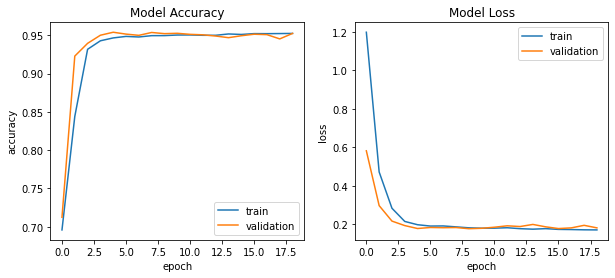

In [120]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

In [ ]:
plot_training_hist(history2)

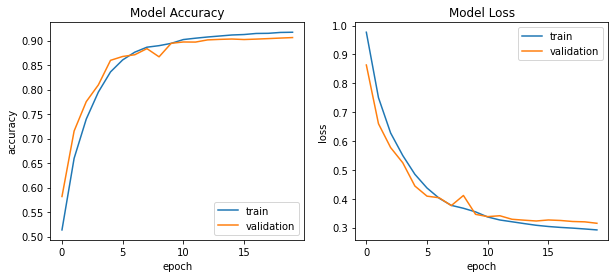

In [71]:
plot_training_hist(history3)

In [121]:
# Evaluate model on the test set
loss, accuracy, precision, recall = modelb.evaluate(X_test, y_test1, verbose=0)
# Print metrics
print('')

print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.9472
Precision : 0.9271
Recall    : 0.9124
F1 Score  : 0.9197


In [ ]:
# Evaluate model on the test set
loss, accuracy, precision, recall = modela.evaluate(X_test2, y_test2, verbose=0)
# Print metrics
print('')

print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))

In [15]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')

print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.9168
Precision : 0.9206
Recall    : 0.9133
F1 Score  : 0.9170


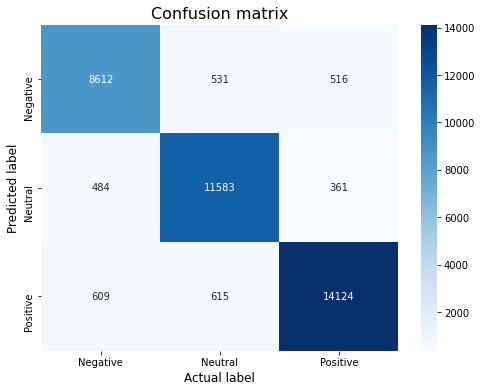

In [16]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

## Actual Training to create full model for sentiment analysis using full set of data<a class="anchor" id="2.3"></a>

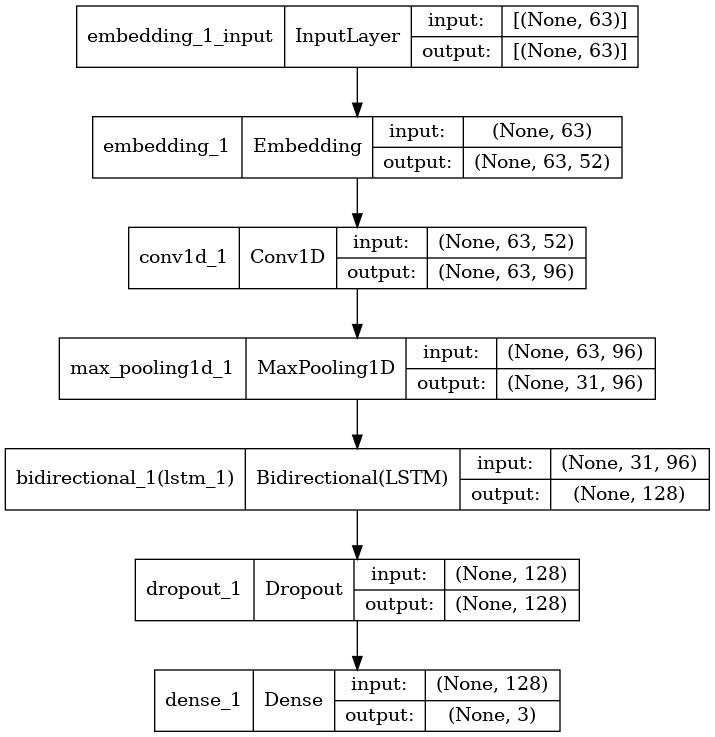

In [18]:
from keras.models import load_model

# Load model
model = load_model('tuned_model.h5')
tf.keras.utils.plot_model(model, show_shapes=True)

In [19]:
# # Compile model
# model.compile(loss='categorical_crossentropy', optimizer=sgd, 
#                metrics=['accuracy','val_loss', Precision(), Recall()])

# # Train model
y = pd.get_dummies(die['category'])
X =sequences
batch_size = 64
stop_early=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=5)
history = model.fit(X, y,
                      batch_size=batch_size, epochs=100, verbose=1,callbacks=[stop_early])

Epoch 1/100
2925/2925 [==============================] - 52s 17ms/step - loss: 0.5667 - accuracy: 0.7656 - precision_1: 0.8220 - recall_1: 0.7041
Epoch 2/100
2925/2925 [==============================] - 50s 17ms/step - loss: 0.2734 - accuracy: 0.9110 - precision_1: 0.9225 - recall_1: 0.9001
Epoch 3/100
2925/2925 [==============================] - 50s 17ms/step - loss: 0.2370 - accuracy: 0.9256 - precision_1: 0.9349 - recall_1: 0.9169
Epoch 4/100
2925/2925 [==============================] - 50s 17ms/step - loss: 0.2190 - accuracy: 0.9325 - precision_1: 0.9407 - recall_1: 0.9249
Epoch 5/100
2925/2925 [==============================] - 50s 17ms/step - loss: 0.2048 - accuracy: 0.9375 - precision_1: 0.9446 - recall_1: 0.9311
Epoch 6/100
2925/2925 [==============================] - 50s 17ms/step - loss: 0.1948 - accuracy: 0.9404 - precision_1: 0.9468 - recall_1: 0.9346
Epoch 7/100
2925/2925 [==============================] - 50s 17ms/step - loss: 0.1865 - accuracy: 0.9433 - precision_1: 0.94

In [10]:
y = pd.get_dummies(die['category']).to_numpy()
y

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

In [12]:
X =sequences
X

array([[  41,    1,  351, ...,    0,    0,    0],
       [ 315,   16,    2, ...,    0,    0,    0],
       [  25,   53,   39, ...,    0,    0,    0],
       ...,
       [1446,  981, 2450, ...,    0,    0,    0],
       [1031,  903,   58, ...,    0,    0,    0],
       [ 903,   63, 1380, ...,    0,    0,    0]], dtype=int32)

In [130]:
# Save the model architecture & the weights
modelb.save('opinio.h5')
print('Best model saved')

Best model saved


# Testing Model<a class="anchor" id="three"></a>
[Contents Page](#m)

In [143]:
from keras.models import load_model

# Load model
model = load_model('opinio.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = ['opinionated','neutral']
    max_len=63
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt)#.argmax(axis=1)
    # Print the predicted sentiment
    print(yt[0][0])
    if yt[0][0]<0.5:
        print('The predicted sentiment is', sentiment_classes[0])
    else:
        print('The predicted sentiment is', sentiment_classes[1])


In [144]:
predict_class(['I have exams'])

0.9664272
The predicted sentiment is neutral


In [145]:
predict_class(['I hate exams'])

0.020236313
The predicted sentiment is opinionated


In [22]:
predict_class(['I hate exams'])

The predicted sentiment is negative


'negative'

In [24]:
predict_class(['I am kinda hungry'])

The predicted sentiment is neutral


'neutral'

In [26]:
predict_class(['The Hope is me'])

The predicted sentiment is neutral


'neutral'

In [27]:
predict_class(['The people are excited about the future'])

The predicted sentiment is positive


'positive'